In [115]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


@Tuan

Generate the dataset in `data_processing.ipynb` and then provide the file paths here.

In [116]:
# Imports
import torch
import numpy as np

In [117]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    mps=False

else:
    mps_device = torch.device("mps")
    mps=True

    print("MPS is available and enabled on device: {}".format(mps_device))

MPS is available and enabled on device: mps


#### Model and Data Initialization

In [118]:
from model import *
from torch.utils.data import DataLoader

windowed_data = "data/X_data.npy"
labels = "data/X_labels.npy"

# Initialize the Dataset
data = GPS_CNN_Dataset(windowed_data, labels, device=mps_device)

train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

# Initialize the DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

X Shape:  torch.Size([47064, 24, 21])
y Shape:  torch.Size([47064])


In [119]:
np.count_nonzero(data.y.cpu())

8015

In [120]:
# initialize the model
model = GPS_CNN(num_bins=21, num_channels=24)
if mps:
    model = model.to(mps_device)
model

GPS_CNN(
  (conv1): Conv1d(24, 8, kernel_size=(5,), stride=(1,), padding=same)
  (pool): MaxPool1d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv1d(8, 4, kernel_size=(5,), stride=(1,), padding=same)
  (fc1): Linear(in_features=92, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

### Training Loop

In [121]:
import torch.optim as optim

weights = torch.FloatTensor([1, 7]).to(mps_device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [122]:
for epoch in range(7):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 700 == 5:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss:.3f}')

    #print("got to eval")
    model.eval()
    correct = 0
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_dataloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    print(f'[{epoch + 1}] loss: {running_loss:.3f}, accuracy: {correct / len(test_dataset):.3f}') 
    model.train()

[1,     6] loss: 0.791
[1,   706] loss: 0.340
[1,  1406] loss: 0.321
[1,  2106] loss: 0.114
[1] loss: 160.180, accuracy: 0.892
[2,     6] loss: 0.294
[2,   706] loss: 0.320
[2,  1406] loss: 0.452
[2,  2106] loss: 0.133
[2] loss: 163.269, accuracy: 0.887
[3,     6] loss: 0.134
[3,   706] loss: 0.174
[3,  1406] loss: 0.157
[3,  2106] loss: 0.066
[3] loss: 160.332, accuracy: 0.886
[4,     6] loss: 0.293
[4,   706] loss: 0.100
[4,  1406] loss: 0.330
[4,  2106] loss: 0.115
[4] loss: 156.843, accuracy: 0.891
[5,     6] loss: 0.480
[5,   706] loss: 0.662
[5,  1406] loss: 0.165
[5,  2106] loss: 0.171
[5] loss: 147.491, accuracy: 0.895
[6,     6] loss: 0.565
[6,   706] loss: 0.071
[6,  1406] loss: 0.494
[6,  2106] loss: 0.724
[6] loss: 146.804, accuracy: 0.893
[7,     6] loss: 0.353
[7,   706] loss: 0.280
[7,  1406] loss: 0.244
[7,  2106] loss: 0.142
[7] loss: 149.060, accuracy: 0.892


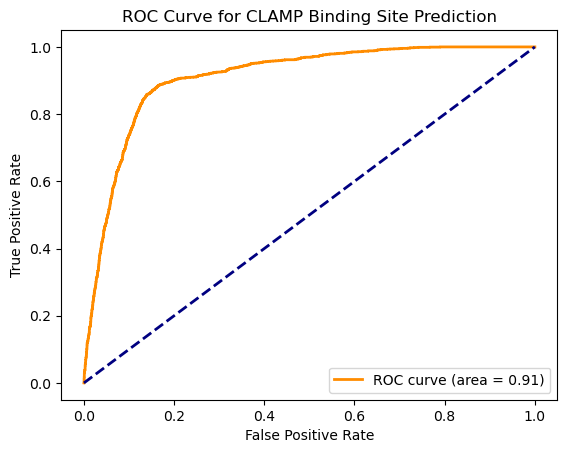

In [123]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_score = []
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_score.extend(outputs.data.cpu().numpy())

y_true = np.array(y_true)
y_score = np.array(y_score)

fpr, tpr, _ = roc_curve((y_true == 1), (y_score[:,1]))
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve for CLAMP Binding Site Prediction')
plt.show()


Text(0.5, 1.0, 'Confusion Matrix for CLAMP Binding Site Prediction')

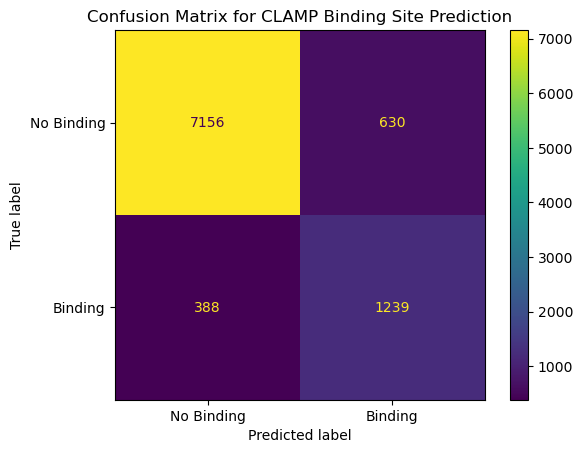

In [124]:
## Make the Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(y_score, axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Binding', 'Binding'], )
disp.plot()
disp.ax_.set_title('Confusion Matrix for CLAMP Binding Site Prediction')
